In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-uc596hqp
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-uc596hqp
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266464 sha256=02bd29a605ea96d5fcca1551dfea82fcee097b1ef2bbe938f26e15913207866c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6eioiowm/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
from os import listdir
from os.path import isfile, join
print(len([f for f in listdir("/content/gdrive/My Drive/nasadata3/PNGImages") if isfile(join("/content/gdrive/My Drive/nasadata3/PNGImages", f))]))
print(len([f for f in listdir("/content/gdrive/My Drive/nasadata3/PedMasks") if isfile(join("/content/gdrive/My Drive/nasadata3/PedMasks", f))]))

87
87


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PennFudanDataset('/content/gdrive/My Drive/nasadata3')

In [ ]:
#torch.randperm(len(dataset)).tolist()

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('/content/gdrive/My Drive/nasadata3', get_transform(train=True))
dataset_test = PennFudanDataset('/content/gdrive/My Drive/nasadata3', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/cuda-repo-ubuntu1604_8.0.61-1_amd64.deb;
!dpkg -i cuda-repo-ubuntu1604_8.0.61-1_amd64.deb;
!apt-get update -qq;
!apt-get install cuda-8.0;
!ln -sf /usr/local/cuda-8.0 /usr/local/cuda

import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda/lib'

!apt-get install gcc-5 g++-5 -y -qq;
!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc;
!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++;
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

--2020-10-04 16:28:42--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/cuda-repo-ubuntu1604_8.0.61-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.20.126
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2690 (2.6K) [application/x-deb]
Saving to: ‘cuda-repo-ubuntu1604_8.0.61-1_amd64.deb.1’

cuda-repo-ubuntu160 100%[===================>]   2.63K  --.-KB/s    in 0s      

2020-10-04 16:28:42 (146 MB/s) - ‘cuda-repo-ubuntu1604_8.0.61-1_amd64.deb.1’ saved [2690/2690]

(Reading database ... 154621 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1604_8.0.61-1_amd64.deb ...
Unpacking cuda-repo-ubuntu1604 (8.0.61-1) over (8.0.61-1) ...
Setting up cuda-repo-ubuntu1604 (8.0.61-1) ...
Note: Check first if apt-key functionality is needed at all - it probably isn't!
OK
Reading pa

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/19]  eta: 0:01:04  lr: 0.000282  loss: 4.7248 (4.7248)  loss_classifier: 0.5917 (0.5917)  loss_box_reg: 0.0520 (0.0520)  loss_mask: 3.9375 (3.9375)  loss_objectness: 0.0543 (0.0543)  loss_rpn_box_reg: 0.0893 (0.0893)  time: 3.4194  data: 2.4114  max mem: 3358
Epoch: [0]  [10/19]  eta: 0:00:07  lr: 0.003058  loss: 1.4701 (2.0785)  loss_classifier: 0.0746 (0.2277)  loss_box_reg: 0.0512 (0.0432)  loss_mask: 1.2584 (1.6461)  loss_objectness: 0.0323 (0.0481)  loss_rpn_box_reg: 0.0949 (0.1135)  time: 0.8185  data: 0.2774  max mem: 4150
Epoch: [0]  [18/19]  eta: 0:00:00  lr: 0.005000  loss: 1.0118 (1.5873)  loss_classifier: 0.0620 (0.1547)  loss_box_reg: 0.0695 (0.0576)  loss_mask: 0.7789 (1.2361)  loss_objectness: 0.0378 (0.0438)  loss_rpn_box_reg: 0.0850 (0.0952)  time: 0.6282  data: 0.1659  max mem: 4150
Epoch: [0] Total time: 0:00:12 (0.6340 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:39  model_time: 0.2409 (0.2409)  evaluator_time: 0.0793 (0.0793)  

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[ 877.3738,    0.0000, 1229.0000,  810.9999],
          [ 671.4592,  171.2137, 1149.3313,  810.9999],
          [   0.0000,    0.0000, 1229.0000,  810.9999],
          [   0.0000,    0.0000,  325.1660,  810.9999],
          [   0.0000,  379.9740, 1132.6019,  810.9999],
          [ 415.4579,    0.0000, 1010.6121,  810.9999],
          [  92.5616,   91.9751,  699.0698,  810.9999],
          [   0.0000,  315.2050,  567.3701,  794.8878],
          [   0.0000,    0.0000,  839.3729,  590.6232],
          [   0.0000,    0.0000,  916.8112,  299.5607],
          [ 599.0923,    0.0000, 1229.0000,  405.0260],
          [ 343.9616,  190.2895, 1229.0000,  696.1332],
          [ 201.0219,    0.0000, 1095.2693,  440.1591]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0503, 0.0448, 0.0393],
            [0.0000, 0.0000, 0.0000,  ..., 0.0539, 0.0480, 0.0421],
            [0.0000, 

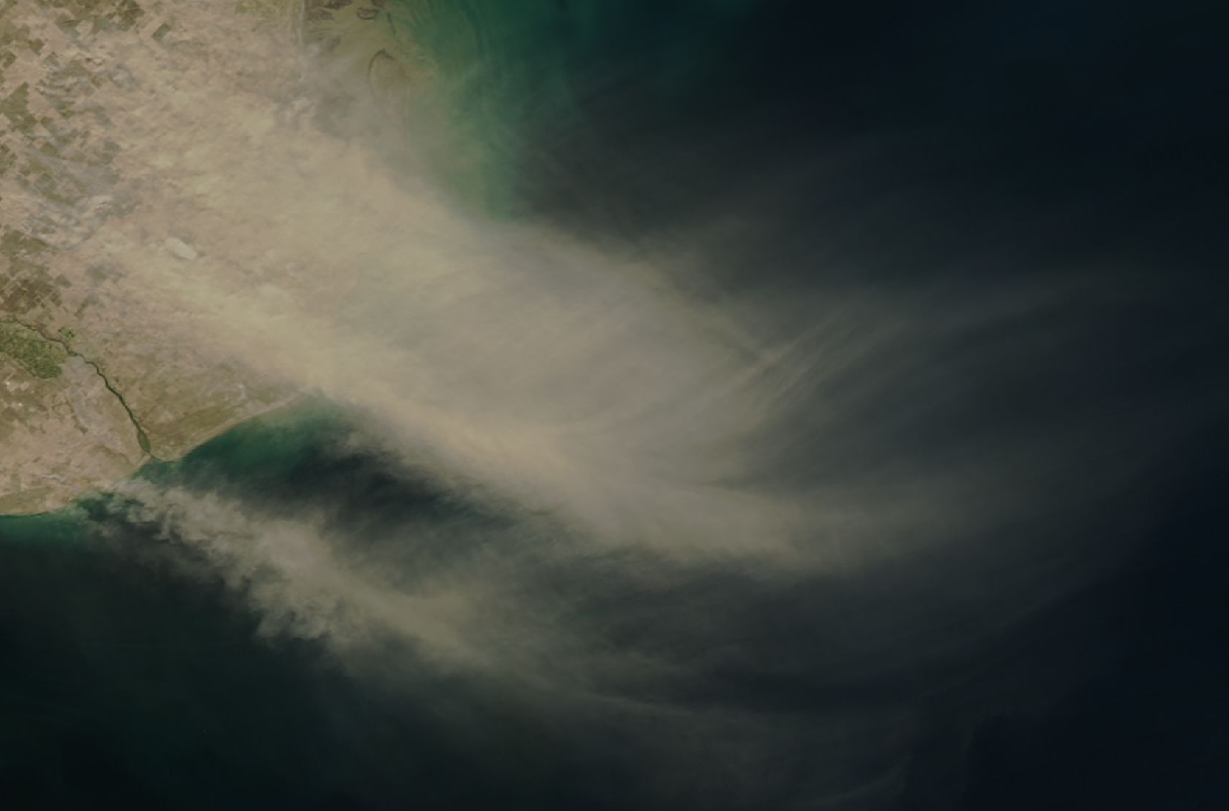

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

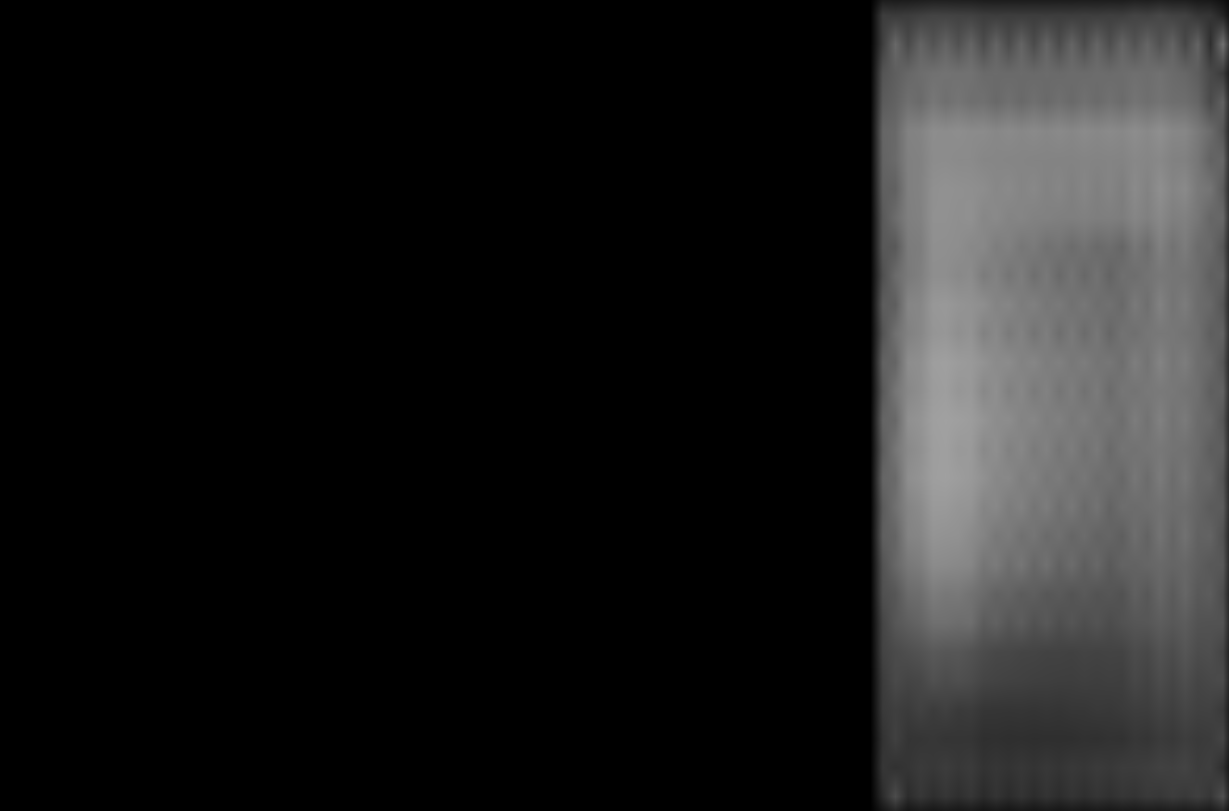

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

# guardar el modelo



In [ ]:
torch.save(model.state_dict(),"/content/gdrive/My Drive/nasadata3/modelo_uno.pth")

In [2]:
import torch
print(torch.__version__)

1.6.0+cu101
